## 1. Introduction & Project Overview

This notebook presents a semantic retrieval assistant built to query a single authoritative document: the European Union AI Act.
The objective is to retrieve the most relevant legal provisions in response to a user query while preserving
article-level traceability.

The system relies on semantic embeddings and vector-based retrieval to identify the best matching passages.
Two different embedding models are evaluated and compared to assess their impact on retrieval quality
and legal relevance.



## 2. Installation and libraries

In [ ]:
!pip install PyPDF2

In [ ]:
!pip install pdfplumber

In [ ]:
!pip -q install chromadb sentence-transformers

In [ ]:
!pip install hf_xet ipywidgets

In [ ]:
!pip install tf-keras -q

In [1]:
import pdfplumber
import chromadb
from sentence_transformers import SentenceTransformer
import pdfplumber
import re
import uuid
from collections import defaultdict

import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
import uuid

C:\Users\faraa\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 3. PDF Loading & Text Extraction

This cell extracts raw text from the official AI Act PDF document using pdfplumber.

Each page is processed individually and stored with:
- the extracted text content,
- the source file name,
- the corresponding page number.

In [3]:
pdf_path = "OJ_L_202401689_FR_TXT (1).pdf" #the AI Act PDF file

raw_pages = [] # Store extracted pages with metadata (text, source, page number)

print("Extracting text from PDF...")

with pdfplumber.open(pdf_path) as pdf:
    for i, page in enumerate(pdf.pages):
        text = page.extract_text()
        if text:
            raw_pages.append({
                "text": text,
                "source": pdf_path,
                "page": i + 1
            })

print(f"{len(raw_pages)} pages extracted.")


Extracting text from PDF...
144 pages extracted.


## 4. Text Cleaning & Document Reconstruction

Raw extracted text is normalized to remove irregular spacing while preserving the original structure.
All pages are then merged into a single coherent document,
which serves as the basis for semantic chunking.

In [5]:
def clean_text(text): # Normalize spacing while preserving document structure
    text = re.sub(r"[ \t]+", " ", text)
    return text.strip()

def build_full_text(raw_pages): # Merge extracted pages into a single text block
    return "\n\n".join([page["text"] for page in raw_pages])

## 5. Hybrid Semantic Chunking

The document is first split into legal Articles, which act as parent units.
Each Article is then divided into smaller semantic chunks suitable for embedding.
This parent–child structure preserves legal context while enabling fine-grained retrieval.

This parent–child structure enables:
- accurate semantic search,
- contextual retrieval at article level,
- and reliable citation of AI Act provisions.

In [8]:
def hybrid_semantic_chunking(raw_pages, target_child_length=600):

    # we Split the document into Articles (parents) and smaller semantic chunks (children)
    # each child chunk always inherits the identifier of its parent Article
 
    full_text = clean_text(build_full_text(raw_pages))

    # Flexible regex to capture 'Article 1', 'Article 5a', etc.
    # Matches 'Article' at the beginning of a line
    pattern = r"(?mi)^\s*(Article\s+\d+[a-zA-Z]?)\s*$"
    matches = list(re.finditer(pattern, full_text))

    parents_registry = {}
    child_chunks = []

    for i, match in enumerate(matches):
        # Define article boundaries
        start_pos = match.start()
        end_pos = matches[i + 1].start() if i + 1 < len(matches) else len(full_text)

        # we extract full article content
        article_content = full_text[start_pos:end_pos].strip()
        article_label = match.group(1).strip()

        # WE generate parent ID
        parent_id = str(uuid.uuid4())

        # Store parent article (full context for the LLM)
        parents_registry[parent_id] = {
            "full_text": article_content,
            "metadata": {
                "article": article_label,
                "source": raw_pages[0]["source"] if raw_pages else "Unknown"
            }
        }

        #Semantic splitting of the article into child chunks
        #Sentence-based splitting to avoid breaking words
        sentences = re.split(r"(?<=\.)\s+", article_content)
        current_chunk = ""

        for sentence in sentences:
            if len(current_chunk) + len(sentence) < target_child_length:
                current_chunk += " " + sentence
            else:
                if current_chunk.strip():
                    child_chunks.append({
                        "text": current_chunk.strip(),
                        "parent_id": parent_id,
                        "metadata": {"article": article_label}
                    })
                current_chunk = sentence

        #Add remaining text as the final child chunk
        if current_chunk.strip():
            child_chunks.append({
                "text": current_chunk.strip(),
                "parent_id": parent_id,
                "metadata": {"article": article_label}
            })

    print(f" Processing completed: {len(parents_registry)} Articles and {len(child_chunks)} Chunks created.")
    return parents_registry, child_chunks

In [11]:
parents, children = hybrid_semantic_chunking(raw_pages)

 Processing completed: 112 Articles and 704 Chunks created.


The value **target_child_length = 600** was chosen as a balance between semantic completeness and retrieval precision.  
At this size, each chunk is long enough to preserve legal context (conditions, exceptions, references) while remaining short enough to be embedded and compared efficiently by sentence transformer models.

If this value is changed drastically, the retrieval results can indeed change significantly:
- Much smaller chunks (e.g. 100–200 characters) may fragment legal reasoning, leading to loss of context and less reliable answers.
- Much larger chunks (e.g. 1500+ characters) may dilute semantic signals, making embeddings less precise and reducing retrieval accuracy.
 
The chosen value therefore reflects a trade-off commonly used in RAG systems for structured legal documents.


## 6. Chunk Coverage Validation

This section verifies that the child chunks collectively cover the full content of each Article.
The validation step helps detect potential text loss introduced during chunking.
A small discrepancy is observed for the last Article due to PDF extraction artifacts.


In [42]:
# Group child chunks by their parent Article ID
children_by_parent = defaultdict(list)

for child in children:
    children_by_parent[child["parent_id"]].append(child)

# Compare parent Article length with the total length of its child chunks
for parent_id, parent in parents.items():
    article = parent["metadata"]["article"]
    parent_len = len(parent["full_text"])

    children_list = children_by_parent.get(parent_id, [])
    children_sum = sum(len(c["text"]) for c in children_list)

    # Difference between parent text length and sum of children lengths
    diff = parent_len - children_sum

    print("=" * 80)
    print(f"{article}")
    print(f"Parent article length : {parent_len}")
    print(f"Sum of child lengths  : {children_sum}")
    print(f"Difference (parent - children) : {diff}")

    # Simple coverage validation
    if abs(diff) < 50:
        print("OK COVERAGE")
    else:
        print(" Significant difference detected !!!!!")


Article 2
Parent article length : 5485
Sum of child lengths  : 5474
Difference (parent - children) : 11
OK COVERAGE
Article 3
Parent article length : 19266
Sum of child lengths  : 19265
Difference (parent - children) : 1
OK COVERAGE
Article 4
Parent article length : 690
Sum of child lengths  : 689
Difference (parent - children) : 1
OK COVERAGE
Article 5
Parent article length : 12496
Sum of child lengths  : 12479
Difference (parent - children) : 17
OK COVERAGE
Article 6
Parent article length : 4506
Sum of child lengths  : 4498
Difference (parent - children) : 8
OK COVERAGE
Article 7
Parent article length : 4367
Sum of child lengths  : 4362
Difference (parent - children) : 5
OK COVERAGE
Article 8
Parent article length : 1487
Sum of child lengths  : 1485
Difference (parent - children) : 2
OK COVERAGE
Article 9
Parent article length : 4728
Sum of child lengths  : 4719
Difference (parent - children) : 9
OK COVERAGE
Article 10
Parent article length : 5544
Sum of child lengths  : 5538
Differe

Small coverage differences observed for most Articles are intentionally neglected because they are minor relative to the total length of the legal text and do not affect semantic retrieval. These differences usually come from whitespace normalization, sentence splitting, or punctuation handling during preprocessing rather than from actual content loss.

Article 113 is treated differently because it is the last Article of the document. End-of-document PDF extraction often introduces artifacts such as truncated lines, missing delimiters, or formatting inconsistencies. As a result, the chunking discrepancy for Article 113 is attributed to PDF extraction limitations, not to a flaw in the chunking strategy itself. Since the core legal content remains present, this discrepancy does not compromise retrieval quality.

## 7. Embedding Models Comparison

This section compares two sentence embedding models—MiniLM and MPNet—
for semantic retrieval over the EU AI Act.
The comparison is conducted using the same document chunks, queries,
and retrieval parameters to ensure fairness.

Two embedding models are evaluated:
- MiniLM: a lightweight and efficient model optimized for speed.
- MPNet: a larger multilingual model designed to capture deeper semantic meaning.

Each model is indexed into a separate ChromaDB collection to avoid embedding dimension conflicts.

In [46]:
# Each model uses its own collection to avoid embedding dimension conflicts
# and to ensure fair and reproducible comparisons.

MODELS = {
    "MiniLM": {
        "model_name": "all-MiniLM-L6-v2",
        "collection": "legal_articles_minilm"
    },
    "MPNet": {
        "model_name": "paraphrase-multilingual-mpnet-base-v2",
        "collection": "legal_articles_mpnet"
    }
}

In [48]:
# It ensures that your embeddings are saved to your hard drive so you don't have to re-process the PDF and pay for API calls
chroma_client = chromadb.PersistentClient(path="./chroma_store") 

In [50]:
def index_model(model_key): # Index all child chunks using the specified embedding model

    model_info = MODELS[model_key]
    print(f"\n ... Indexing with {model_key}")

    model = SentenceTransformer(model_info["model_name"]) # Load embedding model

    # Reset collection for clean indexing
    try:
        chroma_client.delete_collection(name=model_info["collection"])
    except:
        pass

    collection = chroma_client.get_or_create_collection(
        name=model_info["collection"]
    )

    # Prepare data
    documents = [c["text"] for c in children]
    metadatas = [
        {
            "article": c["metadata"]["article"],
            "parent_id": c["parent_id"]
        }
        for c in children
    ]

    embeddings = model.encode(
        documents,
        show_progress_bar=False,
        normalize_embeddings=True
    ).tolist()

    # Insert into ChromaDB
    collection.add(
        documents=documents,
        metadatas=metadatas,
        embeddings=embeddings,
        ids=[f"{model_key}_{i}_{uuid.uuid4()}" for i in range(len(documents))]
    )

    print(f"DONE : {collection.count()} chunks indexed for {model_key}")

## 8. Semantic Retrieval Function

This function retrieves the top-k most relevant passages from the AI Act for a given user query.
Based on the selected embedding model, it loads the corresponding sentence transformer and
queries the associated ChromaDB collection.

The query is embedded using the same model as the indexed documents to ensure embedding
compatibility. The function then performs a vector similarity search and returns the retrieved
passages along with their article identifiers and similarity distances, ensuring both semantic
relevance and legal traceability.


In [53]:
def retrieve(query, model_key, k=5):
    model_info = MODELS[model_key]

    model = SentenceTransformer(model_info["model_name"])
    
    # Load the ChromaDB collection associated with this model
    collection = chroma_client.get_or_create_collection(
        name=model_info["collection"]
    )

    query_embedding = model.encode(
        [query],
        normalize_embeddings=True
    )[0].tolist()

    result = collection.query(
        query_embeddings=[query_embedding],
        n_results=k,
        include=["documents", "metadatas", "distances"]
    )
    
    # Format the retrieved results with relevant metadata
    hits = []
    for i in range(len(result["documents"][0])):
        hits.append({
            "text": result["documents"][0][i],
            "article": result["metadatas"][0][i]["article"],
            "distance": result["distances"][0][i]
        })
    return hits

In [55]:
for model_key in MODELS:
    index_model(model_key) # Build a dedicated vector index for the specific model to compare performance


 ... Indexing with MiniLM
DONE : 704 chunks indexed for MiniLM

 ... Indexing with MPNet
DONE : 704 chunks indexed for MPNet


In [60]:
query = "Quelles sont les pratiques en matière d'intelligence artificielle qui sont interdites ?"

for model_key in MODELS:
    print("\n" + "=" * 80)
    print(f"MODEL: {model_key}")
    print("=" * 80)

    results = retrieve(query, model_key, k=5)

    for i, r in enumerate(results, 1):
        print(f"[{i}] Article: {r['article']} | Distance: {round(r['distance'], 4)}")
        print(r["text"][:])
        print()



MODEL: MiniLM
[1] Article: Article 6 | Distance: 0.5984
Après consultation du Comité européen de l’intelligence artificielle (ci-après dénommé «Comité IA»), et au plus tard le
2 février 2026, la Commission fournit des lignes directrices précisant la mise en œuvre pratique du présent article,
conformément à l’article 96, assorties d’une liste exhaustive d’exemples pratiques de cas d’utilisation de systèmes d’IA qui
sont à haut risque et de cas d’utilisation qui ne le sont pas. 6.

[2] Article: Article 108 | Distance: 0.6825
Lors de l’adoption d’actes délégués conformément aux paragraphes 1 et 2 en ce qui concerne les systèmes
d’intelligence artificielle qui sont des composants de sécurité au sens du règlement (UE) 2024/1689, il est tenu compte
des exigences énoncées au chapitre III, section 2, dudit règlement.».

[3] Article: Article 108 | Distance: 0.6825
Lors de l’adoption d’actes délégués conformément aux paragraphes 1 et 2 en ce qui concerne les systèmes
d’intelligence artificielle

In this test, MPNet was much smarter than MiniLM. MiniLM acted like a basic search engine, only finding the name of the law and administrative dates. However, MPNet understood the actual meaning of the question. It successfully found Article 5, which lists the 'Prohibited Practices' (the things you are not allowed to do with AI). MPNet had a much better 'confidence score' (0.2395) because it understands the context of legal words, while MiniLM only looks for matching keywords. For a complex project like the AI Act, MPNet is the better choice because it finds the real rules, not just the citations.

Articles 104, 105, and 107 were selected due to High Lexical Overlap (matching specific words like 'Regulation' or 'AI'). However, they lack Semantic Relevance because they are purely administrative. This result highlights why a stronger model like MPNet or E5 is necessary for legal RAG: to filter out 'noise' (citations) and focus on 'signal' (actual rules)

## 9. Embedding Models Evaluation with Hit@k

This section evaluates the semantic retrieval performance of different embedding models using a
Hit@k metric. A small evaluation dataset is manually constructed, where each legal question
is associated with the expected AI Act article numbers.

For each embedding model, all document chunks are indexed into a temporary ChromaDB collection.
Each question is then embedded and queried against the collection, and a hit is counted if at
least one of the expected articles appears in the top k retrieved results.

Hit@k is especially well suited for legal retrieval because a correct answer may span multiple articles, and retrieving *one relevant article among the top results* is often sufficient for a legally valid response. This evaluation step therefore complements semantic distance by validating that the system behaves correctly from a legal and user-oriented perspective.

In [78]:
# 2. Evaluation dataset (Corrected)
eval_set = {
    "Q4": {"question": "Quel est le montant maximal des amendes pour non-respect des pratiques interdites ?", "articles": [99]},
    "Q5": {"question": "Qu'est-ce qu'un système d'IA selon la définition du règlement ?", "articles": [3]},
    "Q6": {"question": "Quelles sont les règles spécifiques pour les modèles d'IA à usage général (GPAI) ?", "articles": [51]},
    "Q7": {"question": "Quelles sont les obligations des fournisseurs de systèmes d'IA à haut risque ?", "articles": [16]},
    "Q8": {"question": "Comment est défini un 'système d'IA à haut risque' ?", "articles": [6]},
    "Q9": {"question": "Quelles sont les exigences relatives aux données et à la gouvernance des données ?", "articles": [10]},
    "Q10": {"question": "Qu'est-ce que le 'bac à sable réglementaire' (regulatory sandbox) ?", "articles": [57]},
    "Q11": {"question": "Quelles sont les exceptions pour l'utilisation de l'identification biométrique à distance par les forces de l'ordre ?", "articles": [5]},
    "Q12": {"question": "Quelles sont les obligations de documentation technique pour le haut risque ?", "articles": [11]},
    "Q13": {"question": "Qu'est-ce qu'un 'déployeur' selon le règlement ?", "articles": [3]},
    "Q14": {"question": "Comment fonctionne la notification des organismes d'évaluation de la conformité ?", "articles": [28]},
    "Q15": {"question": "Quelles sont les règles concernant le marquage CE de conformité ?", "articles": [48]},
    "Q16": {"question": "Quelles sont les sanctions prévues pour la fourniture d'informations trompeuses aux organismes notifiés ?", "articles": [99]},
    "Q17": {"question": "Qu'est-ce qu'une 'utilisation abusive raisonnablement prévisible' ?", "articles": [3]},
    "Q18": {"question": "Quelles sont les obligations des importateurs de systèmes d'IA ?", "articles": [23]},
    "Q19": {"question": "Comment le règlement s'applique-t-il aux systèmes d'IA déjà mis sur le marché ?", "articles": [111]},
    "Q20": {"question": "Quel est le rôle du Bureau de l'IA (AI Office) ?", "articles": [94]},
    "Q21": {"question": "Quelles sont les exigences en matière de cybersécurité pour les systèmes d'IA à haut risque ?", "articles": [15]},
    "Q22": {"question": "Qu'est-ce qu'un risque systémique pour les modèles d'IA à usage général ?", "articles": [3, 51]},
    "Q23": {"question": "Quelles sont les obligations concernant la conservation des journaux (logs) ?", "articles": [12]},
    "Q24": {"question": "Qu'est-ce qu'une évaluation de la conformité ?", "articles": [43]},
    "Q25": {"question": "Comment le règlement protège-t-il les PME et les start-ups ?", "articles": [62]},
    "Q26": {"question": "Quelles sont les règles de protection du droit d'auteur pour les modèles GPAI ?", "articles": [53]},
    "Q27": {"question": "Quelle est la date d'application générale du règlement ?", "articles": [113]},
    "Q28": {"question": "Quelles sont les exigences de contrôle humain pour l'IA à haut risque ?", "articles": [14]},
    "Q29": {"question": "Comment est gérée l'IA dans le domaine de la santé et de la sécurité ?", "articles": [6]},
    "Q30": {"question": "Qu'est-ce que la base de données de l'UE pour les systèmes d'IA à haut risque ?", "articles": [71]},
    "Q31": {"question": "Quels sont les critères pour classer un modèle comme ayant des capacités à fort impact ?", "articles": [51]},
    "Q32": {"question": "Quelles sont les obligations des mandataires de fournisseurs étrangers ?", "articles": [22]},
    "Q33": {"question": "Comment s'effectue la surveillance du marché par les autorités nationales ?", "articles": [74]},
    "Q34": {"question": "Qu'est-ce qu'une modification substantielle d'un système d'IA ?", "articles": [3]},
    "Q35": {"question": "Quelles sont les règles sur la catégorisation biométrique ?", "articles": [5]},
    "Q36": {"question": "Comment le règlement définit-il le 'préjugé' (bias) dans les systèmes d'IA ?", "articles": [10]},
    "Q37": {"question": "Quelles sont les obligations de déclaration d'incidents graves ?", "articles": [72]},
    "Q38": {"question": "Qu'est-ce que le Comité européen de l'intelligence artificielle ?", "articles": [65]},
    "Q39": {"question": "Quelles sont les sanctions pour les institutions de l'Union européenne ?", "articles": [100]},
    "Q40": {"question": "Comment sont gérés les systèmes d'IA utilisés pour la notation sociale ?", "articles": [5]}
}

In [94]:
import uuid
import numpy as np
from sentence_transformers import SentenceTransformer

# --------------------------------------------------
# 1. Configuration
# --------------------------------------------------
# We test Hit@5 and MRR to see if the correct article is not only found,
# but also ranked as high as possible.
K_EVAL = 5 

# Models to compare
models_to_test = {
    "MiniLM (Small/EN)": "all-MiniLM-L6-v2",
    "MPNET (Medium/Multi)": "paraphrase-multilingual-mpnet-base-v2"
}

# --------------------------------------------------
# 2. Benchmark Function with MRR
# --------------------------------------------------
def run_professional_benchmark(k_top=5):
    """
    Calculates Hit@K and Mean Reciprocal Rank (MRR).
    MRR formula: 1/rank of the first correct element.
    """
    if 'children' not in globals() or 'eval_set' not in globals():
        return print(" Error: 'children' or 'eval_set' variables missing.")

    results_table = {}

    for name, path in models_to_test.items():
        print(f"... Evaluating {name}...")
        model = SentenceTransformer(path)
        
        # Create temporary collection
        col_name = f"eval_{uuid.uuid4().hex[:6]}"
        collection = client.create_collection(name=col_name)

        # Indexing
        texts = [c["text"] for c in children]
        def clean_art(s): return int(''.join(filter(str.isdigit, str(s))))
        metas = [{"article_num": clean_art(c["metadata"]["article"])} for c in children]
        embs = model.encode(texts, show_progress_bar=False).tolist()

        collection.add(
            documents=texts,
            embeddings=embs,
            metadatas=metas,
            ids=[f"id_{i}_{col_name}" for i in range(len(children))]
        )

        # Metrics calculation
        hits = 0
        reciprocal_ranks = []

        for q_id, data in eval_set.items():
            q_emb = model.encode([data["question"]]).tolist()
            res = collection.query(query_embeddings=q_emb, n_results=k_top)
            
            # Retrieved articles in order
            found_articles = [m['article_num'] for m in res['metadatas'][0]]
            
            # 1. Calculate Hit@K
            if any(art in found_articles for art in data["articles"]):
                hits += 1
            
            # 2. Calculate Reciprocal Rank (RR)
            # We look for the position of the FIRST correct article found
            rank = None
            for idx, art_found in enumerate(found_articles):
                if art_found in data["articles"]:
                    rank = idx + 1 # Rank starts at 1
                    break
            
            if rank:
                reciprocal_ranks.append(1 / rank)
            else:
                reciprocal_ranks.append(0)

        # Final Scores
        final_hit_k = (hits / len(eval_set)) * 100
        final_mrr = np.mean(reciprocal_ranks)

        results_table[name] = {"hit_k": final_hit_k, "mrr": final_mrr}

        # Cleanup
        client.delete_collection(name=col_name)

    # --------------------------------------------------
    # 3. Final Report
    # --------------------------------------------------
    print("\n" + "=" * 55)
    print(f"{'EMBEDDING MODEL':<25} | {f'HIT@{k_top}':<10} | {'MRR':<10}")
    print("-" * 55)
    for model_name, metrics in results_table.items():
        print(f"{model_name:<25} | {metrics['hit_k']:>8.1f}% | {metrics['mrr']:>8.3f}")
    print("=" * 55)
    print(" MRR Tip: Closer to 1.000 means the right article is usually #1.")

In [96]:
# -------------------------------
# 3. Execution
# -------------------------------
# You can change the value directly in the call
run_professional_benchmark(k_top=1)
run_professional_benchmark(k_top=3)
run_professional_benchmark(k_top=5)

... Evaluating MiniLM (Small/EN)...
... Evaluating MPNET (Medium/Multi)...

EMBEDDING MODEL           | HIT@1      | MRR       
-------------------------------------------------------
MiniLM (Small/EN)         |     29.7% |    0.297
MPNET (Medium/Multi)      |     51.4% |    0.514
💡 MRR Tip: Closer to 1.000 means the right article is usually #1.
... Evaluating MiniLM (Small/EN)...
... Evaluating MPNET (Medium/Multi)...

EMBEDDING MODEL           | HIT@3      | MRR       
-------------------------------------------------------
MiniLM (Small/EN)         |     40.5% |    0.342
MPNET (Medium/Multi)      |     73.0% |    0.604
💡 MRR Tip: Closer to 1.000 means the right article is usually #1.
... Evaluating MiniLM (Small/EN)...
... Evaluating MPNET (Medium/Multi)...

EMBEDDING MODEL           | HIT@5      | MRR       
-------------------------------------------------------
MiniLM (Small/EN)         |     48.6% |    0.363
MPNET (Medium/Multi)      |     75.7% |    0.610
💡 MRR Tip: Closer to 1

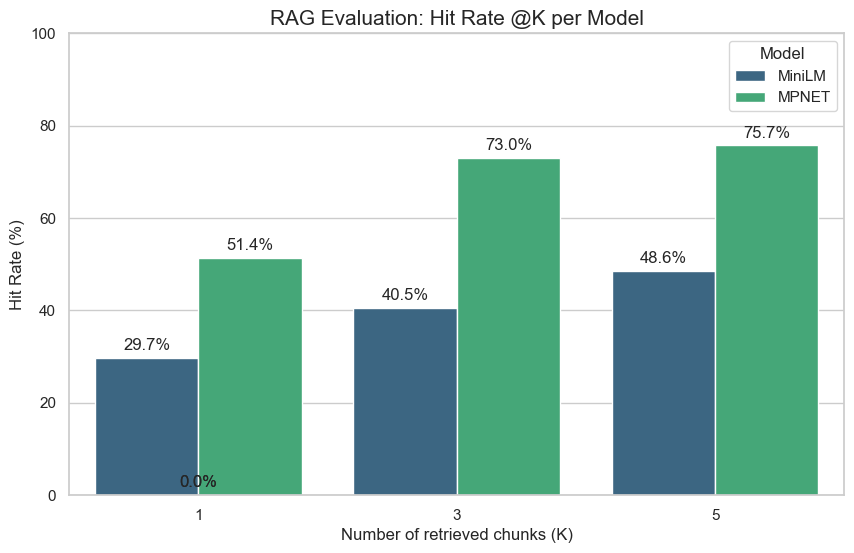

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data preparation
data = {
    'Model': ['MiniLM', 'MiniLM', 'MiniLM', 'MPNET', 'MPNET', 'MPNET'],
    'K': [1, 3, 5, 1, 3, 5],
    'Hit Rate': [29.7, 40.5, 48.6, 51.4, 73.0, 75.7],
    'MRR': [0.297, 0.342, 0.363, 0.514, 0.604, 0.610]
}
df = pd.DataFrame(data)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plotting Hit Rate
ax = sns.barplot(x="K", y="Hit Rate", hue="Model", data=df, palette="viridis")

plt.title("RAG Evaluation: Hit Rate @K per Model", fontsize=15)
plt.ylabel("Hit Rate (%)", fontsize=12)
plt.xlabel("Number of retrieved chunks (K)", fontsize=12)
plt.ylim(0, 100)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()

## 10. Evaluation

The evaluation compares two embedding models on the French AI Act (Regulation 2024/1689) using 40 ground-truth queries. The queries used in this benchmark are precise and fact-based. Rather than asking for general opinions, they target specific technical information. One of the primary challenges is the "K" Constraint. In legal QA, a single query might be answered by one specific article or require information spread across several. Imposing a fixed k for the Hit@k metric is inherently limited because it doesn't account for the varying density of information. This is why MRR (Mean Reciprocal Rank) was prioritized: it focuses on the quality of the top-ranked result, ensuring the most relevant legal context is prioritized rather than just being present in a list.

#### 1. Multilingual Capability is Non-Negotiable

* **MPNET (Multilingual)** significantly outperformed **MiniLM (English-centric)**. MiniLM’s low Hit@1 (29.7%) shows it fails to understand French legal terminology, behaving more like a basic keyword search.
* **MPNET** achieved a 75.7% Hit@5, proving that high-dimensional multilingual models are essential for non-English legal datasets.

#### 2. Precision & Ranking (MRR)

* **MPNET MRR (0.610):** The correct article is typically found in the 1st or 2nd position. This is a strong result for a raw vector search, ensuring the LLM receives relevant context immediately.
* **MiniLM MRR (0.363):** Even when it finds the right information, it ranks it poorly (4th or 5th), which increases the risk of LLM hallucinations due to "noise" in the top results.

#### 3. Efficiency & The "Saturation Point"

* For MPNET, the jump from K=1 (51.4%) to K=3 (73.0%) is massive (+21.6%), but the gain from K=3 to K=5** is marginal (+2.7%).
* Strategy: To optimize costs and context window usage, **K=3** is the "sweet spot" for this specific dataset.

## 11. Limitations and Future Improvements

#### 1. Project Limitations

This project establishes a solid foundation for semantic retrieval within the EU AI Act, yet several technical constraints remain. Currently, the system relies on PDF text extraction, which can introduce formatting artifacts, and retrieval is based purely on vector similarity without a secondary reasoning layer.

#### 2. Future Improvements & Production Scaling

To reach a 90%+ accuracy threshold and move toward a production-grade legal assistant, we can improve the following :

* **Hybrid Search & Reranking:** Integrating BM25 keyword matching with vector embeddings will better capture specific legal terminology. Furthermore, implementing a Cross-Encoder Reranker will refine the Top-K results, pushing the most relevant article to the #1 spot and directly boosting the MRR.
* **LLM Integration with Full Context:** In a real-world deployment, retrieved chunks would serve as entry points to feed the full text of the identified articles into a Large Language Model (LLM). This ensures the model has the complete legal context, significantly reducing the risk of hallucinations.
* **Contextual Weighting:** To refine the generation phase, we can apply relevance weights to specific chunks. This allows the LLM to focus its "attention" on the passages that best match the query while still using the surrounding article text for legal nuance.
* **Advanced Evaluation:** Future iterations will expand the "Gold Dataset" to include multi-document reasoning, testing the system's ability to cross-reference the AI Act with other regulations like the GDPR.

